# Traitement dataset pollution

[![Pollution](https://www.pranaair.com/wp-content/uploads/2018/08/impacts-of-air-pollution.jpg)](https://www.data.gouv.fr/fr/datasets/qualite-de-lair-mesuree-dans-la-station-chatelet/)

### Installation et import bibliothèque

In [6]:
!pip install statsmodels


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from math import sqrt

import pickle
import os

In [15]:
df_pollution = pd.read_csv('pollution.csv', sep=';')
df_pollution

,dateheure,nocha4,n2cha4,10cha4,c2cha4,tcha4,hycha4
0,2024-03-24T23:00:00+00:00,ND,26,23,503,"18,3",38
1,2024-03-24T22:00:00+00:00,<2,33,23,518,"18,4","37,2"
2,2024-03-24T21:00:00+00:00,<2,31,23,524,"18,6","36,6"
3,2024-03-24T20:00:00+00:00,ND,20,28,536,"18,6","36,2"
4,2024-03-24T19:00:00+00:00,ND,18,42,567,"18,2","35,7"
...,...,...,...,...,...,...,...
98194,2013-01-01T04:00:00+00:00,4,26,102,622,"21,2","45,9"
98195,2013-01-01T03:00:00+00:00,3,25,85,715,"21,6","45,8"
98196,2013-01-01T02:00:00+00:00,4,27,124,799,"21,8",47
98197,2013-01-01T01:00:00+00:00,6,30,166,800,"21,6","47,3"


In [16]:
df_pollution.info()
print(df_pollution.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98199 entries, 0 to 98198
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   dateheure  98199 non-null  object
 1   nocha4     76871 non-null  object
 2   n2cha4     84809 non-null  object
 3   10cha4     85583 non-null  object
 4   c2cha4     85896 non-null  object
 5   tcha4      87615 non-null  object
 6   hycha4     87626 non-null  object
dtypes: object(7)
memory usage: 5.2+ MB
dateheure        0
nocha4       21328
n2cha4       13390
10cha4       12616
c2cha4       12303
tcha4        10584
hycha4       10573
dtype: int64


In [17]:
df_pollution = df_pollution.rename(columns={"dateheure": "Date", "nocha4": "NO", "n2cha4": "NO2", "10cha4": "PM10", "c2cha4": "CO2", "tcha4": "Temp", "hycha4": "Humidite"}, errors="raise")
df_pollution['NO'] = df_pollution['NO'].str.replace('ND', '0')
df_pollution['NO'] = df_pollution['NO'].str.replace('<', '')
df_pollution['NO'] = df_pollution['NO'].str.replace('>', '')
df_pollution['NO2'] = df_pollution['NO2'].str.replace('ND', '0')
df_pollution['NO2'] = df_pollution['NO2'].str.replace('<', '')
df_pollution['NO2'] = df_pollution['NO2'].str.replace('>', '')
df_pollution['PM10'] = df_pollution['PM10'].str.replace('ND', '0')
df_pollution['PM10'] = df_pollution['PM10'].str.replace('<', '')
df_pollution['PM10'] = df_pollution['PM10'].str.replace('>', '')
df_pollution['CO2'] = df_pollution['CO2'].str.replace('ND', '0')
df_pollution['CO2'] = df_pollution['CO2'].str.replace('<', '')
df_pollution['CO2'] = df_pollution['CO2'].str.replace('>', '')
df_pollution['Temp'] = df_pollution['Temp'].str.replace('ND', '0')
df_pollution['Temp'] = df_pollution['Temp'].str.replace('<', '')
df_pollution['Temp'] = df_pollution['Temp'].str.replace('>', '')
df_pollution['Temp'] = df_pollution['Temp'].replace(',','.', regex=True).astype(float)
df_pollution['Humidite'] = df_pollution['Humidite'].str.replace('ND', '0')
df_pollution['Humidite'] = df_pollution['Humidite'].str.replace('<', '')
df_pollution['Humidite'] = df_pollution['Humidite'].str.replace('>', '')
df_pollution['Humidite'] = df_pollution['Humidite'].replace(',','.', regex=True).astype(float)
df_pollution.dropna(subset=['NO'], inplace=True)
df_pollution.dropna(subset=['NO2'], inplace=True)
df_pollution.dropna(subset=['PM10'], inplace=True)
df_pollution.dropna(subset=['CO2'], inplace=True)
df_pollution.dropna(subset=['Humidite'], inplace=True)
df_pollution

,Date,NO,NO2,PM10,CO2,Temp,Humidite
0,2024-03-24T23:00:00+00:00,0,26,23,503,18.3,38.0
1,2024-03-24T22:00:00+00:00,2,33,23,518,18.4,37.2
2,2024-03-24T21:00:00+00:00,2,31,23,524,18.6,36.6
3,2024-03-24T20:00:00+00:00,0,20,28,536,18.6,36.2
4,2024-03-24T19:00:00+00:00,0,18,42,567,18.2,35.7
...,...,...,...,...,...,...,...
98194,2013-01-01T04:00:00+00:00,4,26,102,622,21.2,45.9
98195,2013-01-01T03:00:00+00:00,3,25,85,715,21.6,45.8
98196,2013-01-01T02:00:00+00:00,4,27,124,799,21.8,47.0
98197,2013-01-01T01:00:00+00:00,6,30,166,800,21.6,47.3


In [18]:
df_pollution['NO'] = df_pollution.NO.astype(float)
df_pollution['NO2'] = df_pollution.NO2.astype(float)
df_pollution['PM10'] = df_pollution.PM10.astype(float)
df_pollution['CO2'] = df_pollution.CO2.astype(float)
df_pollution['Temp'] = df_pollution.Temp.astype(float)
df_pollution['Temp'] = df_pollution.Temp.astype(float)
df_pollution.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73496 entries, 0 to 98198
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      73496 non-null  object 
 1   NO        73496 non-null  float64
 2   NO2       73496 non-null  float64
 3   PM10      73496 non-null  float64
 4   CO2       73496 non-null  float64
 5   Temp      73496 non-null  float64
 6   Humidite  73496 non-null  float64
dtypes: float64(6), object(1)
memory usage: 4.5+ MB


In [19]:
df_pollution['Date'] = pd.to_datetime(df_pollution['Date'])
df_pollution_min = df_pollution[~(df_pollution['Date'] < '2019-01-01')]
df_pollution_min

,Date,NO,NO2,PM10,CO2,Temp,Humidite
0,2024-03-24 23:00:00+00:00,0.0,26.0,23.0,503.0,18.3,38.0
1,2024-03-24 22:00:00+00:00,2.0,33.0,23.0,518.0,18.4,37.2
2,2024-03-24 21:00:00+00:00,2.0,31.0,23.0,524.0,18.6,36.6
3,2024-03-24 20:00:00+00:00,0.0,20.0,28.0,536.0,18.6,36.2
4,2024-03-24 19:00:00+00:00,0.0,18.0,42.0,567.0,18.2,35.7
...,...,...,...,...,...,...,...
45660,2019-01-01 04:00:00+00:00,13.0,38.0,24.0,519.0,17.1,46.3
45661,2019-01-01 03:00:00+00:00,14.0,36.0,24.0,546.0,17.3,47.3
45662,2019-01-01 02:00:00+00:00,18.0,36.0,43.0,611.0,17.5,48.6
45663,2019-01-01 01:00:00+00:00,22.0,38.0,52.0,580.0,17.6,47.3


In [20]:
# df_pollution['Date'] = pd.to_datetime(df_pollution['Date'])
# df_pollution = df_pollution_i[~(df_pollution_i['Date'] < '2019-01-01')]
df_pollution_i = df_pollution_min.set_index('Date').sort_index()
for col in df_pollution_i.columns:
    df_pollution_i[col] = df_pollution_i[col].fillna(round(df_pollution_i[col].mean(), 2))
df_pollution_i

,NO,NO2,PM10,CO2,Temp,Humidite
Date,,,,,,
2019-01-01 00:00:00+00:00,17.0,35.0,42.0,527.0,17.4,45.6
2019-01-01 01:00:00+00:00,22.0,38.0,52.0,580.0,17.6,47.3
2019-01-01 02:00:00+00:00,18.0,36.0,43.0,611.0,17.5,48.6
2019-01-01 03:00:00+00:00,14.0,36.0,24.0,546.0,17.3,47.3
2019-01-01 04:00:00+00:00,13.0,38.0,24.0,519.0,17.1,46.3
...,...,...,...,...,...,...
2024-03-24 19:00:00+00:00,0.0,18.0,42.0,567.0,18.2,35.7
2024-03-24 20:00:00+00:00,0.0,20.0,28.0,536.0,18.6,36.2
2024-03-24 21:00:00+00:00,2.0,31.0,23.0,524.0,18.6,36.6


In [21]:
# Regroupement des valeurs par jour
df_daily = round(df_pollution_i.resample('D').mean(), 2)
df_daily

,NO,NO2,PM10,CO2,Temp,Humidite
Date,,,,,,
2019-01-01 00:00:00+00:00,12.08,31.67,45.08,508.46,16.96,46.38
2019-01-02 00:00:00+00:00,8.29,30.92,54.21,534.67,16.56,39.10
2019-01-03 00:00:00+00:00,13.71,38.54,53.50,537.29,16.11,40.30
2019-01-04 00:00:00+00:00,14.83,35.08,54.88,530.21,15.90,39.90
2019-01-05 00:00:00+00:00,8.79,31.88,44.25,555.08,15.68,37.14
...,...,...,...,...,...,...
2024-03-20 00:00:00+00:00,31.17,46.88,55.88,618.42,19.75,50.86
2024-03-21 00:00:00+00:00,2.83,34.67,48.04,586.58,19.83,50.60
2024-03-22 00:00:00+00:00,3.46,26.08,49.08,572.46,19.63,53.41


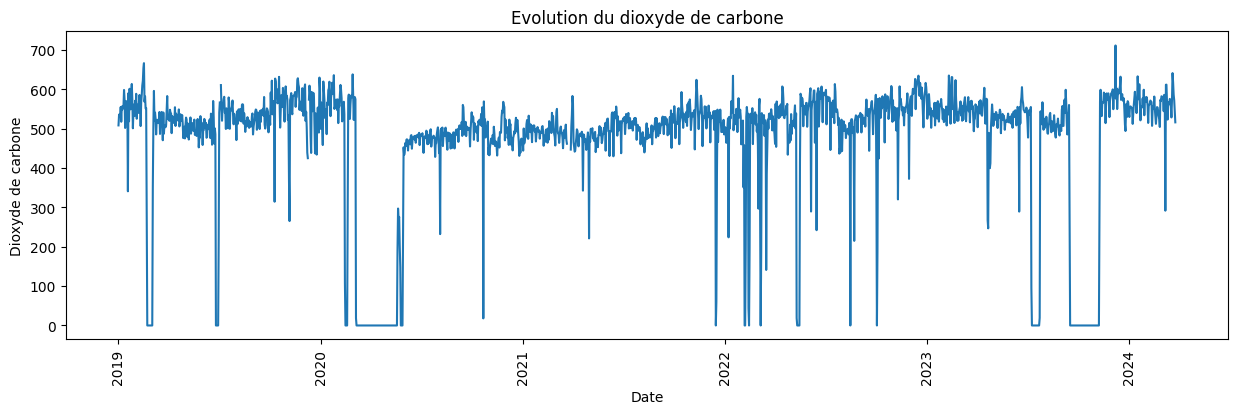

In [30]:
plt.figure(figsize=(15,4))
plt.plot(df_daily['CO2'])
plt.gca().set(title='Evolution du dioxyde de carbone', xlabel='Date', ylabel='Dioxyde de carbone')
plt.xticks(rotation=90)
plt.show()

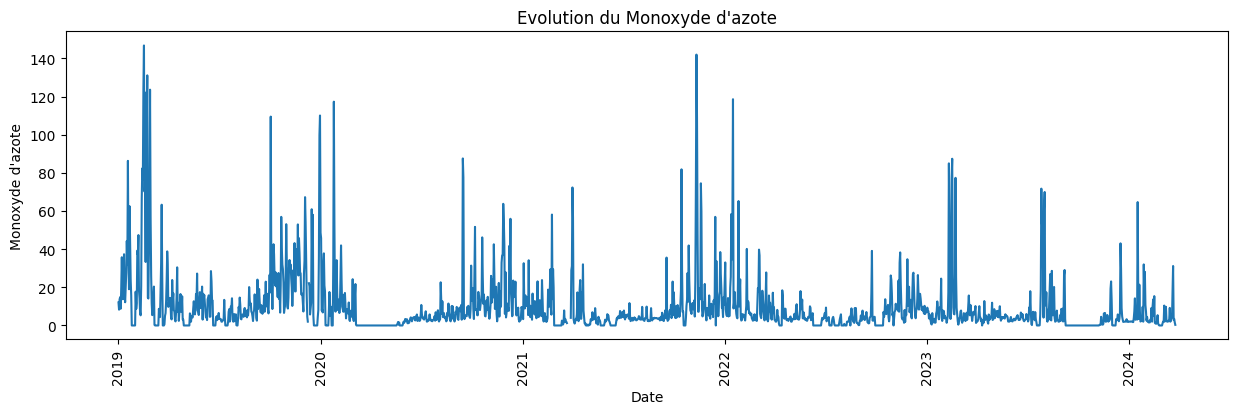

In [28]:
plt.figure(figsize=(15,4))
plt.plot(df_daily['NO'])
plt.gca().set(title='Evolution du Monoxyde d\'azote', xlabel='Date', ylabel='Monoxyde d\'azote')
plt.xticks(rotation=90)
plt.show()

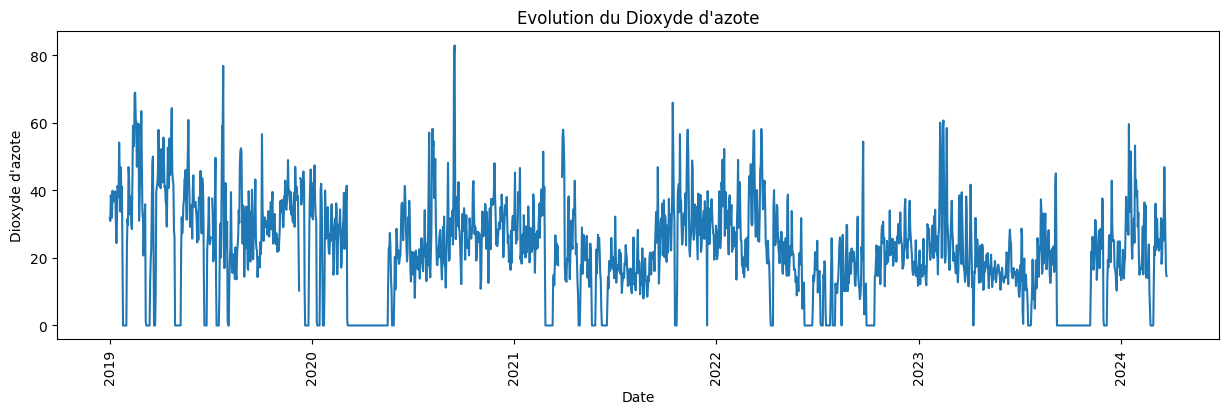

In [29]:
plt.figure(figsize=(15,4))
plt.plot(df_daily['NO2'])
plt.gca().set(title='Evolution du Dioxyde d\'azote', xlabel='Date', ylabel='Dioxyde d\'azote')
plt.xticks(rotation=90)
plt.show()

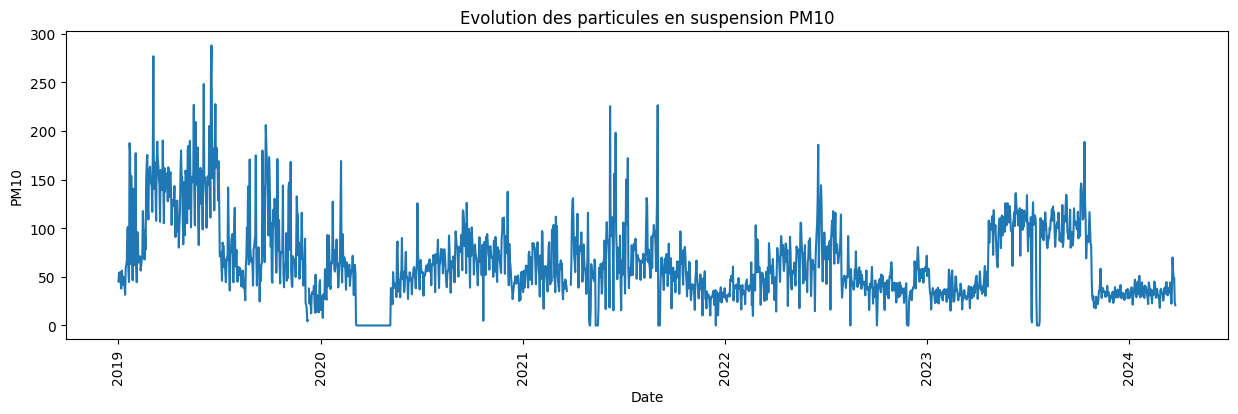

In [31]:
plt.figure(figsize=(15,4))
plt.plot(df_daily['PM10'])
plt.gca().set(title='Evolution des particules en suspension PM10', xlabel='Date', ylabel='PM10')
plt.xticks(rotation=90)
plt.show()

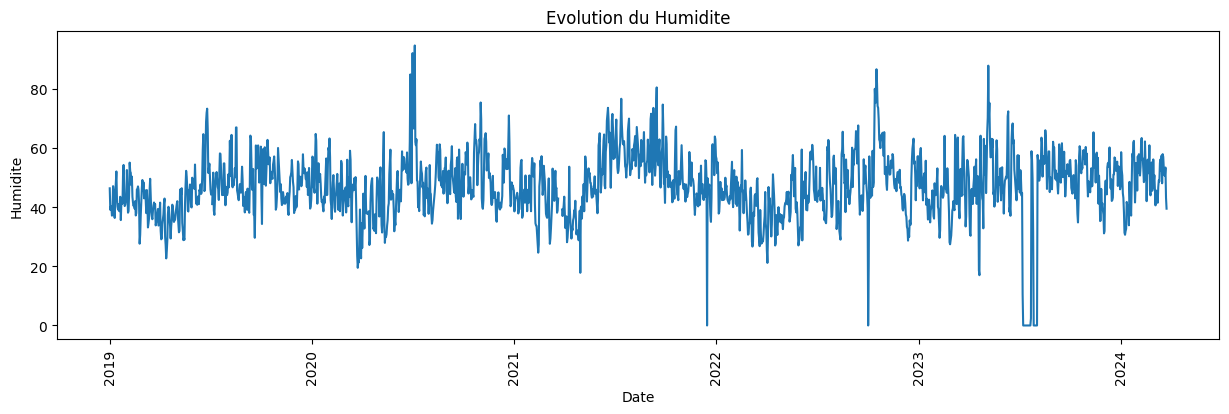

In [26]:
plt.figure(figsize=(15,4))
plt.plot(df_daily['Humidite'])
plt.gca().set(title='Evolution du Humidite', xlabel='Date', ylabel='Humidite')
plt.xticks(rotation=90)
plt.show()

Difficile de faire une corélation 